In [3]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
mypath = r"C:\Users\sidsr\Data"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 
#print(filenames)

In [7]:
max_pad_len = 862

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [10]:
filepaths = [join(mypath, f) for f in filenames]


In [11]:
p_diag = pd.read_csv("audio.csv",header=None)

In [12]:
print(p_diag)

                       0        1
0      A3_AE_breathy.wav  breathy
1    A3_AE_breathy_2.wav  breathy
2         A3_AE_flow.wav     flow
3      A3_AE_neutral.wav  neutral
4      A3_AE_pressed.wav  pressed
..                   ...      ...
904     h4_Y_breathy.wav  breathy
905        h4_Y_flow.wav     flow
906     h4_Y_neutral.wav  neutral
907     h4_Y_pressed.wav  pressed
908   h4_Y_pressedta.wav  pressed

[909 rows x 2 columns]


In [13]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in filenames])

In [14]:
print(labels)

['breathy' 'breathy' 'flow' 'neutral' 'pressed' 'pressed' 'breathy'
 'breathy' 'flow' 'neutral' 'pressed' 'pressed' 'breathy' 'breathy' 'flow'
 'neutral' 'pressed' 'pressed' 'breathy' 'breathy' 'flow' 'neutral'
 'pressed' 'pressed' 'breathy' 'breathy' 'flow' 'neutral' 'pressed'
 'pressed' 'breathy' 'breathy' 'flow' 'neutral' 'pressed' 'pressed'
 'breathy' 'breathy' 'flow' 'neutral' 'pressed' 'pressed' 'breathy'
 'breathy' 'flow' 'neutral' 'pressed' 'pressed' 'breathy' 'breathy' 'flow'
 'neutral' 'pressed' 'pressed' 'breathy' 'flow' 'neutral' 'pressed'
 'pressed' 'breathy' 'flow' 'flow' 'neutral' 'pressed' 'pressed' 'breathy'
 'flow' 'neutral' 'pressed' 'pressed' 'breathy' 'neutral' 'pressed'
 'pressed' 'breathy' 'flow' 'flow' 'neutral' 'pressed' 'pressed' 'breathy'
 'flow' 'neutral' 'pressed' 'pressed' 'breathy' 'flow' 'flow' 'neutral'
 'pressed' 'pressed' 'breathy' 'flow' 'neutral' 'pressed' 'pressed'
 'breathy' 'neutral' 'pressed' 'pressed' 'breathy' 'flow' 'neutral'
 'pressed' 'pres

In [15]:
features = [] 

for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  909  files


In [16]:
print(features)

[[[-7.74881822e+02 -7.66073605e+02 -7.66855403e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.54292395e+01  3.15383806e+01  3.02735522e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-4.43060436e+00 -6.35913605e+00 -7.15413051e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-4.70744830e+00 -1.58742716e+00  1.49190076e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.25541204e+00 -2.47785287e+00 -1.87483670e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.06960011e-01 -7.47987242e-01 -1.60754059e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-7.67329366e+02 -7.54498352e+02 -7.27360571e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.77024728e+01  3.86480031e+01  5.13373989e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.17299108e-01 -1.11964950e+01 -4.49800491e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-5.94064568e+00 -1.8

In [17]:
features = np.array(features)

In [19]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(unique_elements, counts_elements)

['breathy' 'flow' 'neutral' 'pressed'] [247 145 230 287]


In [20]:
le = LabelEncoder()
i_labels = le.fit_transform(labels)
oh_labels = to_categorical(i_labels)

In [23]:
features = np.reshape(features, (*features.shape,1))

In [24]:
print(features)

[[[[-7.74881822e+02]
   [-7.66073605e+02]
   [-7.66855403e+02]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 2.54292395e+01]
   [ 3.15383806e+01]
   [ 3.02735522e+01]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[-4.43060436e+00]
   [-6.35913605e+00]
   [-7.15413051e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  ...

  [[-4.70744830e+00]
   [-1.58742716e+00]
   [ 1.49190076e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[-3.25541204e+00]
   [-2.47785287e+00]
   [-1.87483670e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[-3.06960011e-01]
   [-7.47987242e-01]
   [-1.60754059e+00]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]]


 [[[-7.67329366e+02]
   [-7.54498352e+02]
   [-7.27360571e+02]
   ...
   [ 0.00000000e+00]
   [ 0.00000000e+00]
   [ 0.00000000e+00]]

  [[ 3.77024728e+01]
   [ 3.86480031e+01]
   [

In [26]:
x_train, x_test, y_train, y_test = train_test_split(features, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [27]:

num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2


model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [28]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [29]:
num_epochs = 250
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 727 samples, validate on 182 samples
Epoch 1/250
727/727 [==============================] - 13s 18ms/sample - loss: 1.7718 - acc: 0.2957 - val_loss: 1.3448 - val_acc: 0.2527
Epoch 2/250
727/727 [==============================] - 9s 13ms/sample - loss: 1.4227 - acc: 0.3191 - val_loss: 1.3015 - val_acc: 0.3352
Epoch 3/250
727/727 [==============================] - 10s 14ms/sample - loss: 1.3056 - acc: 0.3755 - val_loss: 1.2641 - val_acc: 0.4451
Epoch 4/250
727/727 [==============================] - 10s 14ms/sample - loss: 1.2498 - acc: 0.3838 - val_loss: 1.2276 - val_acc: 0.5330
Epoch 5/250
727/727 [==============================] - 10s 14ms/sample - loss: 1.1872 - acc: 0.4635 - val_loss: 1.1735 - val_acc: 0.5495
Epoch 6/250
727/727 [==============================] - 10s 14ms/sample - loss: 1.1272 - acc: 0.5076 - val_loss: 1.1201 - val_acc: 0.5440
Epoch 7/250
727/727 [==============================] - 9s 13ms/sample - loss: 1.0575 - acc: 0.5241 - val_loss: 1.0587 - val_acc: 0.56

727/727 [==============================] - 10s 13ms/sample - loss: 0.6284 - acc: 0.7098 - val_loss: 0.7225 - val_acc: 0.7418
Epoch 29/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.5956 - acc: 0.7359 - val_loss: 0.6136 - val_acc: 0.7637
Epoch 30/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.5935 - acc: 0.7483 - val_loss: 0.6818 - val_acc: 0.7747
Epoch 31/250
727/727 [==============================] - 10s 13ms/sample - loss: 0.5391 - acc: 0.8129 - val_loss: 0.6825 - val_acc: 0.7582
Epoch 32/250
727/727 [==============================] - 10s 13ms/sample - loss: 0.5328 - acc: 0.7758 - val_loss: 0.6101 - val_acc: 0.7912
Epoch 33/250
727/727 [==============================] - 10s 13ms/sample - loss: 0.5484 - acc: 0.7854 - val_loss: 0.5986 - val_acc: 0.8077
Epoch 34/250
727/727 [==============================] - 10s 13ms/sample - loss: 0.5096 - acc: 0.7964 - val_loss: 0.7020 - val_acc: 0.7418
Epoch 35/250
727/727 [===========================

727/727 [==============================] - 9s 13ms/sample - loss: 0.3693 - acc: 0.8597 - val_loss: 0.4446 - val_acc: 0.8791
Epoch 56/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.3556 - acc: 0.8583 - val_loss: 0.5839 - val_acc: 0.7802
Epoch 57/250
727/727 [==============================] - 9s 12ms/sample - loss: 0.3416 - acc: 0.8638 - val_loss: 0.4741 - val_acc: 0.8516
Epoch 58/250
727/727 [==============================] - 8s 11ms/sample - loss: 0.3129 - acc: 0.8927 - val_loss: 0.4898 - val_acc: 0.7912
Epoch 59/250
727/727 [==============================] - 8s 11ms/sample - loss: 0.3626 - acc: 0.8487 - val_loss: 0.5282 - val_acc: 0.8242
Epoch 60/250
727/727 [==============================] - 9s 12ms/sample - loss: 0.3416 - acc: 0.8721 - val_loss: 0.5164 - val_acc: 0.7857
Epoch 61/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.3223 - acc: 0.8900 - val_loss: 0.4519 - val_acc: 0.8407
Epoch 62/250
727/727 [==============================] 

Epoch 83/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2437 - acc: 0.9023 - val_loss: 0.4617 - val_acc: 0.8352
Epoch 84/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2450 - acc: 0.9010 - val_loss: 0.4283 - val_acc: 0.8407
Epoch 85/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2823 - acc: 0.8845 - val_loss: 0.4183 - val_acc: 0.8462
Epoch 86/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2239 - acc: 0.9230 - val_loss: 0.4798 - val_acc: 0.8407
Epoch 87/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2435 - acc: 0.8982 - val_loss: 0.3798 - val_acc: 0.8736
Epoch 88/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2399 - acc: 0.9092 - val_loss: 0.4936 - val_acc: 0.8022
Epoch 89/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2609 - acc: 0.9078 - val_loss: 0.4201 - val_acc: 0.8407
Epoch 90/250
727/727 [===================

727/727 [==============================] - 9s 13ms/sample - loss: 0.1653 - acc: 0.9354 - val_loss: 0.4770 - val_acc: 0.8132
Epoch 111/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.1858 - acc: 0.9243 - val_loss: 0.3464 - val_acc: 0.8681
Epoch 112/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.1888 - acc: 0.9298 - val_loss: 0.3834 - val_acc: 0.8681
Epoch 113/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2297 - acc: 0.9051 - val_loss: 0.4645 - val_acc: 0.8132
Epoch 114/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2529 - acc: 0.8982 - val_loss: 0.3824 - val_acc: 0.8626
Epoch 115/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.1723 - acc: 0.9395 - val_loss: 0.3989 - val_acc: 0.8242
Epoch 116/250
727/727 [==============================] - 9s 13ms/sample - loss: 0.2148 - acc: 0.9188 - val_loss: 0.4052 - val_acc: 0.8626
Epoch 117/250
727/727 [=========================

Epoch 138/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1713 - acc: 0.9340 - val_loss: 0.3378 - val_acc: 0.8791
Epoch 139/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1732 - acc: 0.9326 - val_loss: 0.4055 - val_acc: 0.8681
Epoch 140/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1437 - acc: 0.9505 - val_loss: 0.3318 - val_acc: 0.8626
Epoch 141/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1676 - acc: 0.9326 - val_loss: 0.3482 - val_acc: 0.8901
Epoch 142/250
727/727 [==============================] - 11s 14ms/sample - loss: 0.1625 - acc: 0.9367 - val_loss: 0.4548 - val_acc: 0.8571
Epoch 143/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1622 - acc: 0.9298 - val_loss: 0.3407 - val_acc: 0.8846
Epoch 144/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1345 - acc: 0.9519 - val_loss: 0.3795 - val_acc: 0.8462
Epoch 145/250
727/727 [====

727/727 [==============================] - 10s 14ms/sample - loss: 0.1432 - acc: 0.9532 - val_loss: 0.3814 - val_acc: 0.8516
Epoch 166/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1294 - acc: 0.9491 - val_loss: 0.3522 - val_acc: 0.8626
Epoch 167/250
727/727 [==============================] - 11s 15ms/sample - loss: 0.1237 - acc: 0.9436 - val_loss: 0.4023 - val_acc: 0.8407
Epoch 168/250
727/727 [==============================] - 11s 15ms/sample - loss: 0.1218 - acc: 0.9587 - val_loss: 0.3175 - val_acc: 0.8901
Epoch 169/250
727/727 [==============================] - 11s 15ms/sample - loss: 0.1260 - acc: 0.9601 - val_loss: 0.3457 - val_acc: 0.8571
Epoch 170/250
727/727 [==============================] - 11s 14ms/sample - loss: 0.1241 - acc: 0.9505 - val_loss: 0.3370 - val_acc: 0.8791
Epoch 171/250
727/727 [==============================] - 11s 15ms/sample - loss: 0.1190 - acc: 0.9574 - val_loss: 0.4044 - val_acc: 0.8297
Epoch 172/250
727/727 [==================

727/727 [==============================] - 10s 14ms/sample - loss: 0.1163 - acc: 0.9519 - val_loss: 0.3661 - val_acc: 0.8571
Epoch 193/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1223 - acc: 0.9615 - val_loss: 0.2961 - val_acc: 0.8956
Epoch 194/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1186 - acc: 0.9546 - val_loss: 0.3576 - val_acc: 0.8571
Epoch 195/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1531 - acc: 0.9326 - val_loss: 0.2524 - val_acc: 0.8791
Epoch 196/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1813 - acc: 0.9243 - val_loss: 0.4164 - val_acc: 0.8407
Epoch 197/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1262 - acc: 0.9519 - val_loss: 0.4377 - val_acc: 0.8242
Epoch 198/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1532 - acc: 0.9354 - val_loss: 0.3597 - val_acc: 0.8516
Epoch 199/250
727/727 [==================

727/727 [==============================] - 10s 13ms/sample - loss: 0.1160 - acc: 0.9532 - val_loss: 0.3329 - val_acc: 0.8626
Epoch 220/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1088 - acc: 0.9574 - val_loss: 0.2735 - val_acc: 0.8736
Epoch 221/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1007 - acc: 0.9629 - val_loss: 0.4418 - val_acc: 0.8516
Epoch 222/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1038 - acc: 0.9629 - val_loss: 0.2890 - val_acc: 0.8901
Epoch 223/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1172 - acc: 0.9546 - val_loss: 0.3515 - val_acc: 0.8736
Epoch 224/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.0796 - acc: 0.9739 - val_loss: 0.3083 - val_acc: 0.8791
Epoch 225/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1043 - acc: 0.9574 - val_loss: 0.3699 - val_acc: 0.8516
Epoch 226/250
727/727 [==================

727/727 [==============================] - 10s 14ms/sample - loss: 0.0973 - acc: 0.9642 - val_loss: 0.2935 - val_acc: 0.8846
Epoch 247/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1064 - acc: 0.9601 - val_loss: 0.2911 - val_acc: 0.8626
Epoch 248/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.0926 - acc: 0.9587 - val_loss: 0.3238 - val_acc: 0.8791
Epoch 249/250
727/727 [==============================] - 10s 13ms/sample - loss: 0.0780 - acc: 0.9807 - val_loss: 0.3479 - val_acc: 0.8791
Epoch 250/250
727/727 [==============================] - 10s 14ms/sample - loss: 0.1020 - acc: 0.9697 - val_loss: 0.3460 - val_acc: 0.8846
Training completed in time:  0:41:10.777145


In [30]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.96148556
Testing Accuracy:  0.88461536


In [35]:
model.save('model2')

In [36]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=4 # number of classes

In [37]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [38]:
c_names = ['breathy', 'flow', 'neutral' ,'pressed']

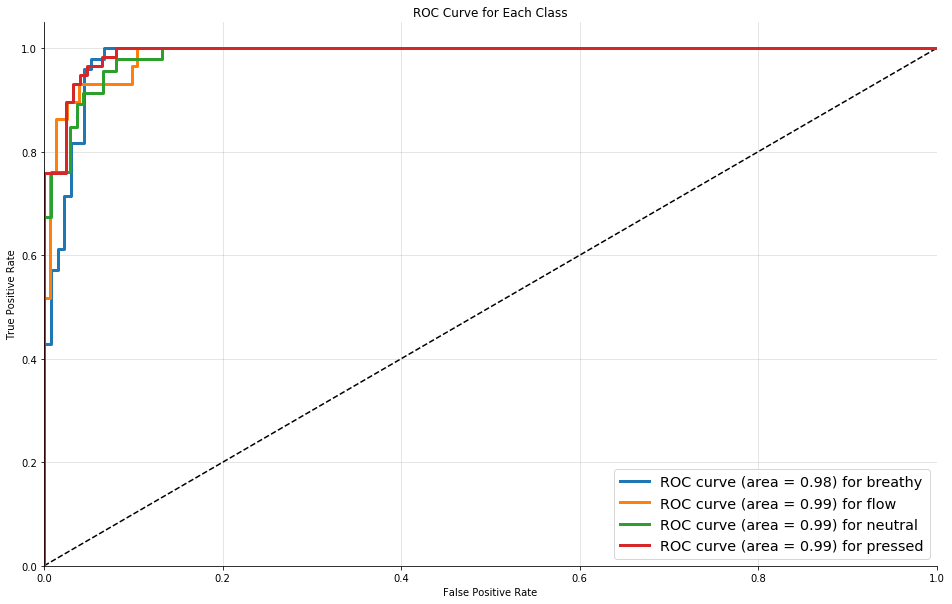

In [39]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()